<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Options" data-toc-modified-id="Options-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Options</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Filter-data" data-toc-modified-id="Filter-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Filter data</a></span></li></ul></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Cluster-with-k-means" data-toc-modified-id="Cluster-with-k-means-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cluster with k-means</a></span></li><li><span><a href="#Deciding-on-number-of-clusters" data-toc-modified-id="Deciding-on-number-of-clusters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Deciding on number of clusters</a></span><ul class="toc-item"><li><span><a href="#Silhouette-score" data-toc-modified-id="Silhouette-score-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Silhouette score</a></span></li><li><span><a href="#Davies–Bouldin-index" data-toc-modified-id="Davies–Bouldin-index-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Davies–Bouldin index</a></span></li></ul></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualize</a></span></li><li><span><a href="#Chart-the-returns-of-the-formed-clustes" data-toc-modified-id="Chart-the-returns-of-the-formed-clustes-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Chart the returns of the formed clustes</a></span></li><li><span><a href="#Analysing-clusters" data-toc-modified-id="Analysing-clusters-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Analysing clusters</a></span></li></ul></div>

# Clustering

## Description

- Cluster funds using k-means

## Setup

In [55]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD

### Options

In [72]:
year             = 2010

style_class      = 'lipper_class' # Choose lipper_class, style_class or cap_class
n_clusters       = 11              # Number of neighbors to use in k-nn algorithm
n_init           = 50 

### Load Data

In [73]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
returns = returns.rename(columns = {'caldt' : 'report_dt'})
returns = returns.assign(year = returns['report_dt'].dt.year)

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

### Filter data 

In [74]:
row_info_f = row_info.query('year == @year')

begin_date = row_info_f.iloc[0,:]['report_dt']
end_date = begin_date + pd.DateOffset(years=1,months=1,days = 5)
row_info_f.reset_index(drop = True, inplace=True)

# Filter returns
crsp_fundno_unique = row_info_f['crsp_fundno'].unique()
returns_f = returns.copy()
query = '''report_dt >= @begin_date and report_dt <= @end_date and crsp_fundno in @crsp_fundno_unique'''
returns_f = returns_f.query(query)

# Change return of month for which holdings apply to 0
mask = returns_f['report_dt'] == begin_date
returns_f.loc[mask,'mret'] = 0

# Filter holdings accordingly and delet all empty columns
holdings_f = holdings[row_info_f['row']]
col_sums = pd.DataFrame(holdings_f.sum(0).T).values 
mask = (col_sums != 0).flatten()
holdings_f = holdings_f[:,mask]

print('Numer of unique funds:      {:10,d}'.format(row_info_f.shape[0]))
print('Begin date:                 {}'.format(begin_date.date()))
print('End date:                   {}'.format(end_date.date()))

Numer of unique funds:           2,145
Begin date:                 2010-12-31
End date:                   2012-02-05


## Preprocessing

In [75]:
transformer = Normalizer().fit(holdings_f)
holdings_ft = transformer.transform(holdings_f)

## Cluster with k-means

In [76]:
print('Start kMeans...')
kmeans = KMeans(n_clusters = n_clusters,
                verbose = True,
                n_init = n_init, # Number of runs
                n_jobs= -1,
                random_state = 1
               ).fit(holdings_ft)

row_info_f = row_info_f.assign(cluster = kmeans.labels_)

Start kMeans...


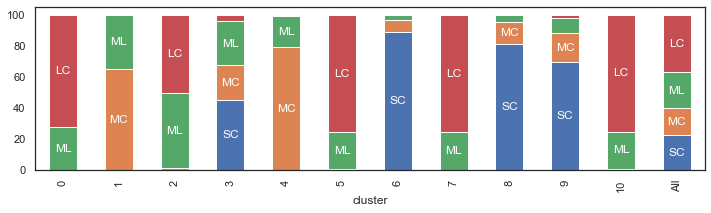

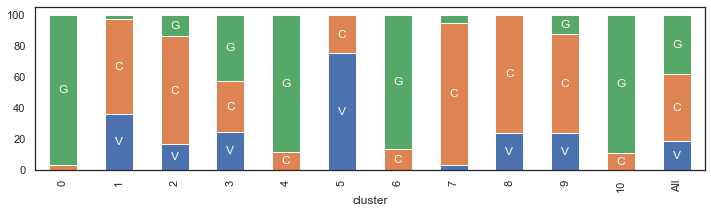

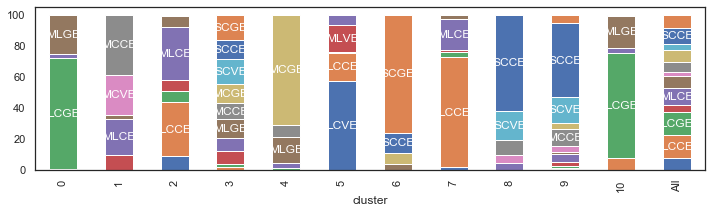

In [77]:
plot_cluster(row_info_f,'cap_class')
plot_cluster(row_info_f,'style_class')
plot_cluster(row_info_f,'lipper_class')

In [7]:
def plot_cluster(row_info_f,style):
    sns.set()
    sns.set_style("white")
    data = round(
        pd.crosstab(
            row_info_f[style],row_info_f['cluster'], 
            margins = True, normalize = 'columns') * 100, 2).T

    ax = data.plot(kind='bar', 
                 stacked=True, 
                 figsize=(12,3))

    #ax.legend(bbox_to_anchor=(1, 1))
    ax.legend().remove()
    label_list = data.columns.values.astype(str).repeat(data.shape[0])
    rects = ax.patches

    # For each bar: Place a label
    for i, rect in enumerate(rects):
        if rect.get_height() > 10:
            # Get X and Y placement of label from rect.
            x_value = rect.get_x() + rect.get_width() / 2
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 0


            # Use X value as label and format number with one decimal place
            label = "{}".format(label_list[i])

            # Create annotation
            plt.annotate(
                label,                        # Use `label` as label
                (x_value, y_value),           # Place label at end of the bar
                xytext = (space, 0),          # Horizontally shift label by `space`
                textcoords = 'offset points', # Interpret `xytext` as offset in points
                va='center',                  # Vertically center label
                ha='center',
                color = 'white',
                size = 12)                  # Horizontally align label 
    plt.show()

## Deciding on number of clusters

### Silhouette score 

### Davies–Bouldin index

In [61]:
#Source: 
# https://stackoverflow.com/questions/48036593/is-my-python-implementation-of-the-davies-bouldin-index-correct
# https://en.wikipedia.org/wiki/Davies–Bouldin_index

def DaviesBouldin(X, labels):
    X = X.toarray()
    n_cluster = len(np.bincount(labels))
    cluster_k = [X[labels == k] for k in range(n_cluster)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]

    # calculate cluster dispersion
    S = [np.mean([euclidean(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    Ri = []

    for i in range(n_cluster):
        Rij = []
        # establish similarity between each cluster and all other clusters
        for j in range(n_cluster):
            if j != i:
                r = (S[i] + S[j]) / euclidean(centroids[i], centroids[j])
                Rij.append(r)
        # select Ri value of most similar cluster
        Ri.append(max(Rij)) 

    # get mean of all Ri values    
    dbi = np.mean(Ri)

    return(dbi)

In [62]:
DaviesBouldin(holdings_ft, row_info_f['cluster'])

KeyError: 'cluster'

In [70]:
for i in np.arange(2,9):
    print('Start kMeans:                {}'.format(i))

    kmeans = KMeans(n_clusters = i,
                    verbose = True,
                    n_init = n_init, # Number of runs
                    n_jobs= -1,
                    random_state = 1
                   ).fit(holdings_ft)

    row_info_f = row_info_f.assign(cluster = kmeans.labels_)
    db = DaviesBouldin(holdings_ft, row_info_f['cluster'])

    print('Db score for {} cluster:     {}'.format(i,db))

Start kMeans:                2
Db score for 2 cluster:     3.799664329974437
Start kMeans:                3
Db score for 3 cluster:     3.3073025508360523
Start kMeans:                4
Db score for 4 cluster:     5.143369992902414
Start kMeans:                5
Db score for 5 cluster:     5.0003231158702395
Start kMeans:                6
Db score for 6 cluster:     4.937670748627507
Start kMeans:                7
Db score for 7 cluster:     4.759575394124189
Start kMeans:                8
Db score for 8 cluster:     4.959701326149968


In [71]:
for i in np.arange(9,13):
    print('Start kMeans:                {}'.format(i))

    kmeans = KMeans(n_clusters = i,
                    verbose = True,
                    n_init = n_init, # Number of runs
                    n_jobs= -1,
                    random_state = 1
                   ).fit(holdings_ft)

    row_info_f = row_info_f.assign(cluster = kmeans.labels_)
    db = DaviesBouldin(holdings_ft, row_info_f['cluster'])

    print('Db score for {} cluster:     {}'.format(i,db))

Start kMeans:                9
Db score for 9 cluster:     4.856869774673949
Start kMeans:                10
Db score for 10 cluster:     5.232764557086606
Start kMeans:                11
Db score for 11 cluster:     4.697466921403907
Start kMeans:                12
Db score for 12 cluster:     5.185972831719914


## Visualize

For n_clusters = 2 The average silhouette_score is: 0.0625
For n_clusters = 3 The average silhouette_score is: 0.0449
For n_clusters = 4 The average silhouette_score is: 0.0476
For n_clusters = 5 The average silhouette_score is: 0.0469
For n_clusters = 6 The average silhouette_score is: 0.0296
For n_clusters = 7 The average silhouette_score is: 0.0318
For n_clusters = 8 The average silhouette_score is: 0.0335
For n_clusters = 9 The average silhouette_score is: 0.0347
For n_clusters = 10 The average silhouette_score is: -0.0111
For n_clusters = 11 The average silhouette_score is: 0.0222
For n_clusters = 12 The average silhouette_score is: 0.0309
For n_clusters = 13 The average silhouette_score is: 0.0182
For n_clusters = 14 The average silhouette_score is: 0.0195
For n_clusters = 18 The average silhouette_score is: 0.0172
For n_clusters = 25 The average silhouette_score is: 0.0173


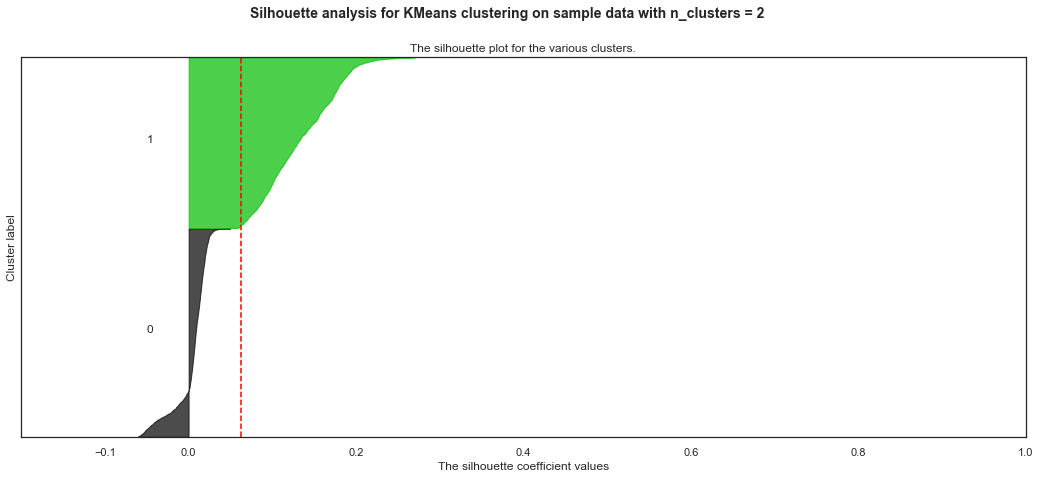

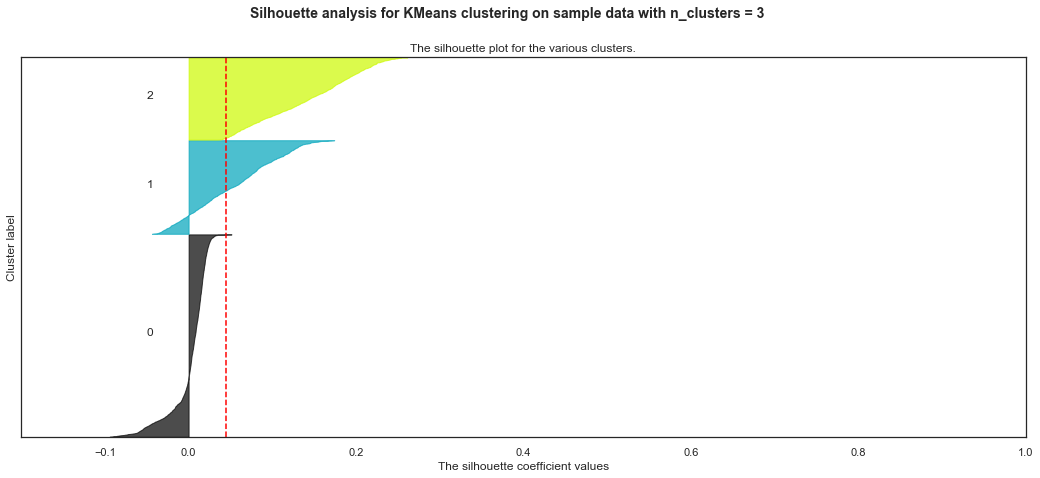

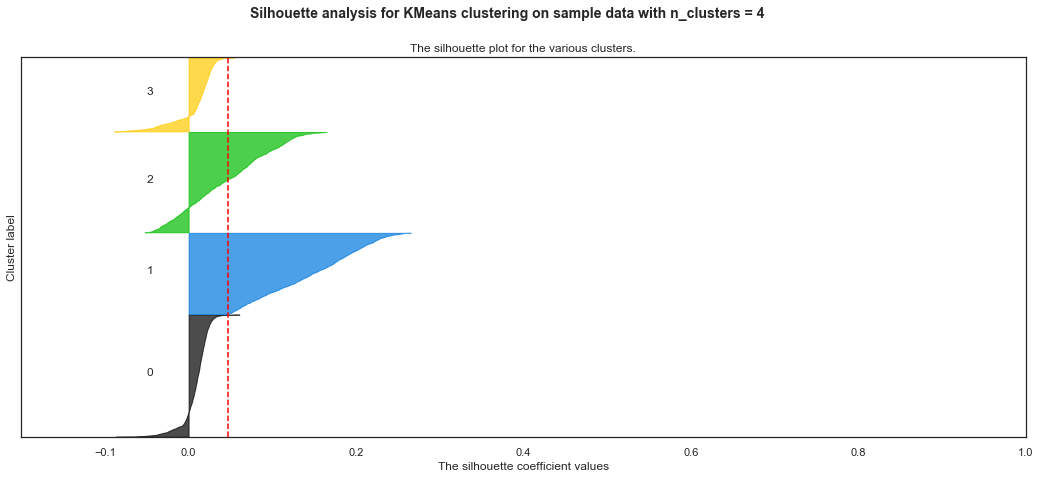

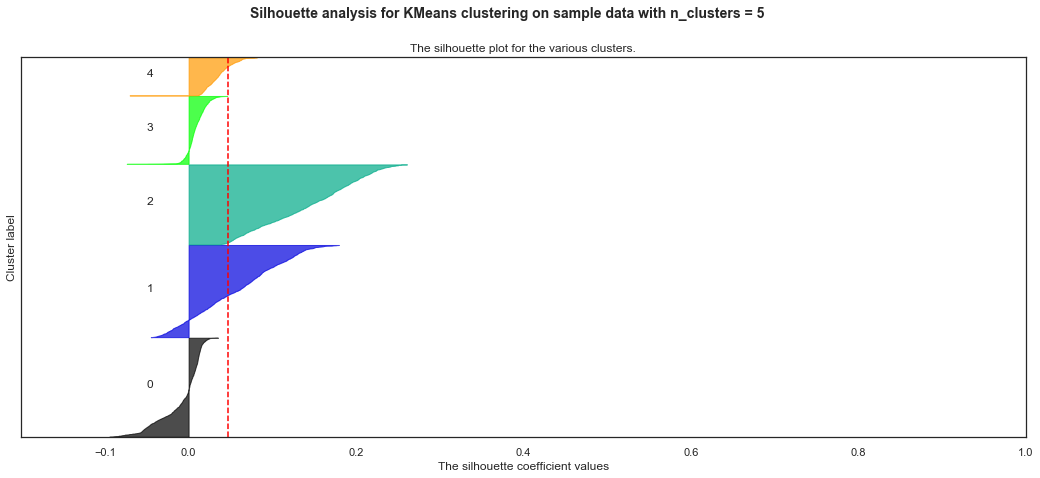

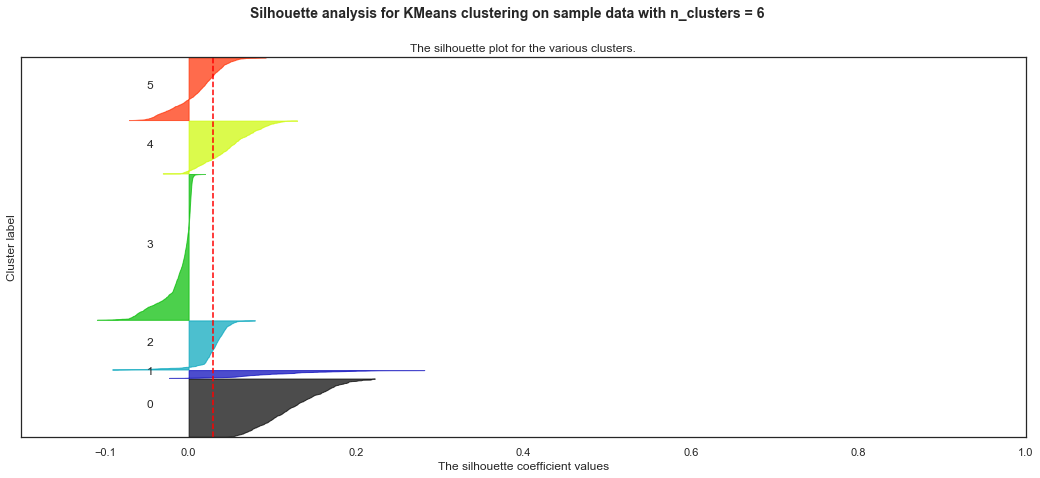

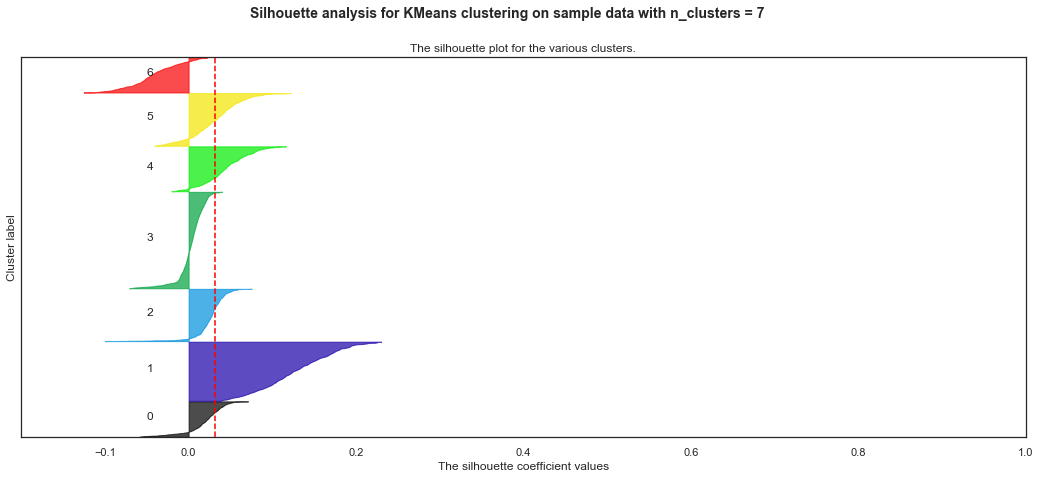

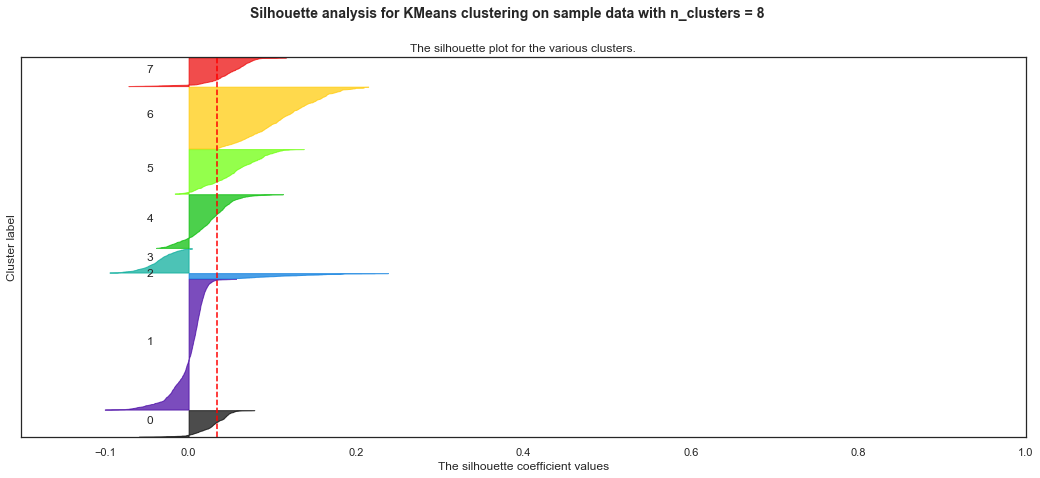

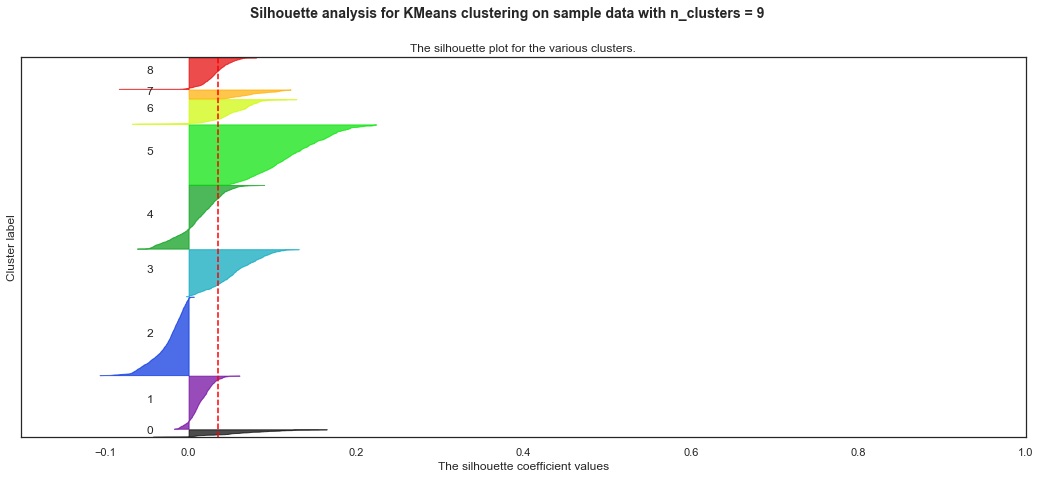

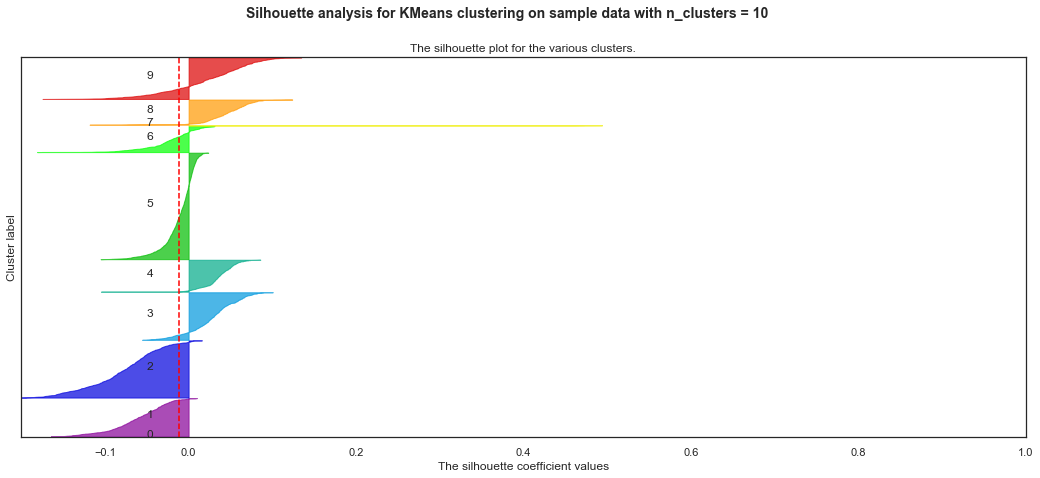

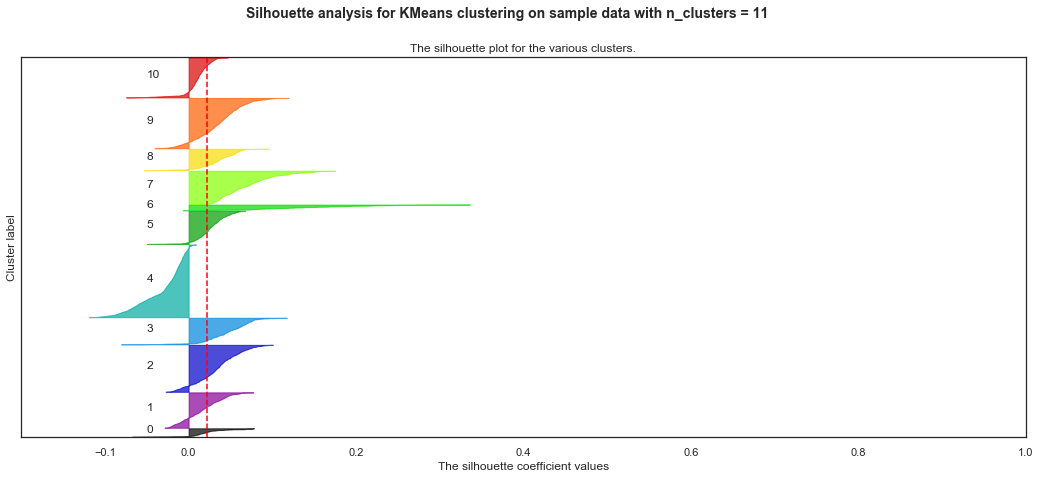

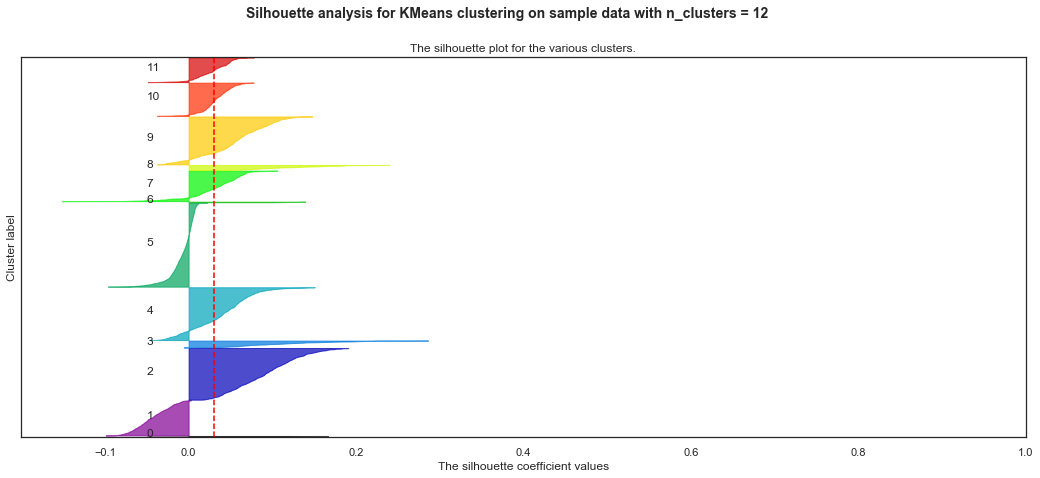

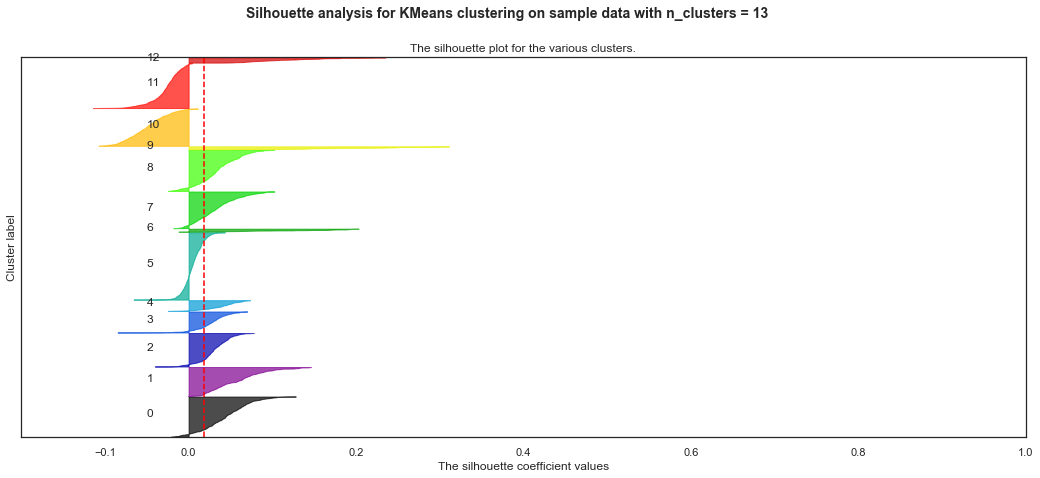

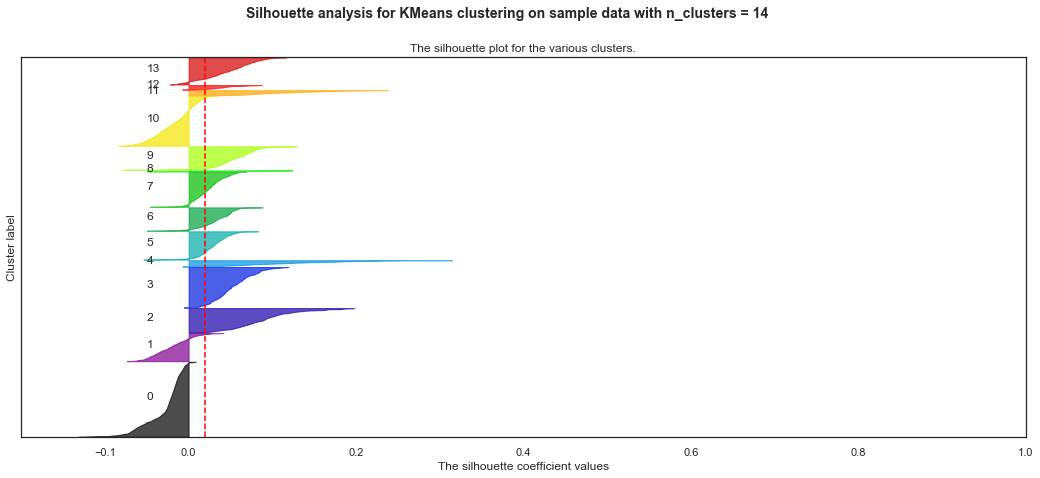

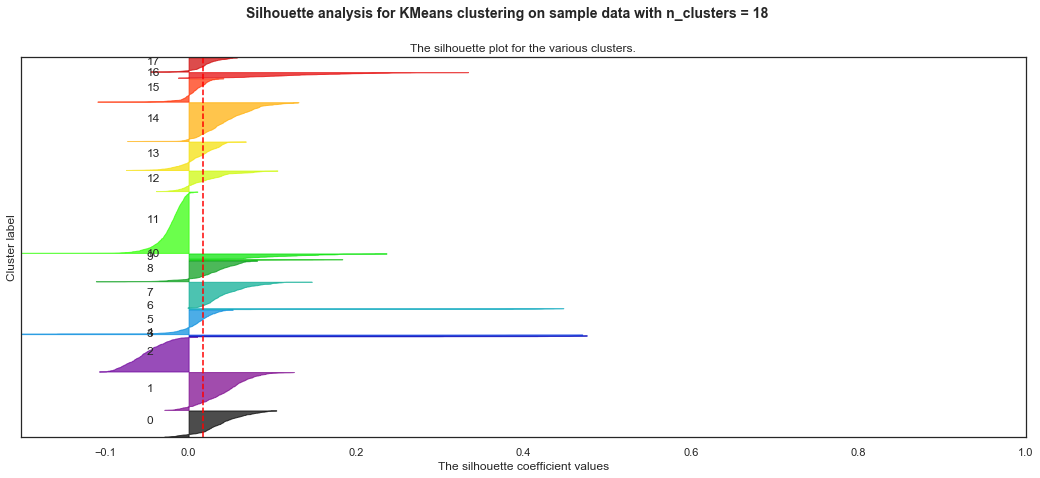

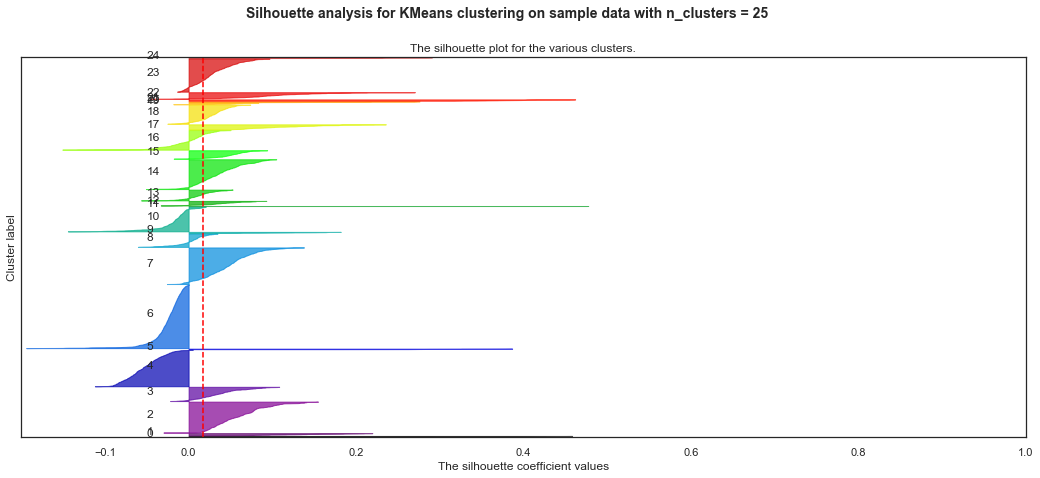

In [21]:
### Based on example code from sklearn ###

X = holdings_ft
n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,18,25]

clusters = []
results = []

for n_clusters in n_clusters:
    clusterer = MiniBatchKMeans(
                    n_clusters=n_clusters,
                    verbose = False,
                    n_init = 1000)
    
    
    cluster_fit = clusterer.fit(X)
    clusters.append(n_clusters)
    results.append(cluster_fit.inertia_)    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          'The average silhouette_score is: {}'.format(round(silhouette_avg,4)))

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Chart the returns of the formed clustes

In [242]:
row_info.sample()

,port_no,report_dt,fund_name,avrcs,lipper_class,False,cap_class,style_class,fund_no,cluster
99859,1026163,2017-12-31,"Principal Funds, Inc: LargeCap Growth Fund; Cl...",96.197692,LCGE,LCVE,L,G,24862,0


#### Merge new clusters into returns

In [243]:
returns_merged = returns.merge(row_info, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged = returns_merged[['caldt','fund_no','crsp_portno','mret','lipper_class','cluster']]
returns_merged.sample()

,caldt,fund_no,port_no,mret,lipper_class,cluster
49902,2017-11-30,31946.0,1022128.0,0.035377,MLGE,0.0


#### Calc mean return per Obj_cd

In [244]:
cluster_codes = returns_merged[['cluster']].drop_duplicates()
cluster_codes = cluster_codes['cluster'].values
cluster_codes

array([0., 1., 3., 2.])

In [245]:
# Analysis of selected funds
returns_clus = returns_merged.groupby(['cluster','caldt'])['mret'].agg(['mean','count','std'])
returns_clus['cumret'] = returns_clus.groupby('cluster')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [246]:
returns_clus = returns_clus.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns='cluster')

returns_clus.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Analysing clusters

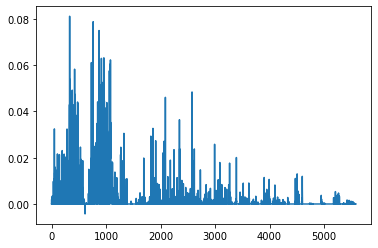

In [30]:
plt.plot(kmeans.cluster_centers_[0,:])

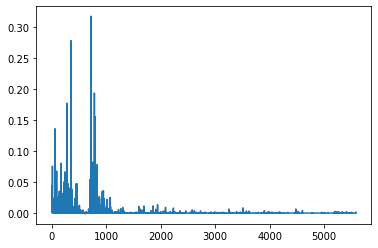

In [31]:
plt.plot(kmeans.cluster_centers_[1,:])